In [30]:
# 1) Setup & localização da raiz do projeto
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

def find_repo_root(start: Path | None = None) -> Path:
    """Sobe diretórios até encontrar uma pasta com 'artifacts' e 'app'."""
    cur = start or Path.cwd()
    for p in [cur, *cur.parents]:
        if (p / "artifacts").is_dir() and (p / "app").is_dir():
            return p
    # fallback: se não achar, usa cwd
    return cur

ROOT = find_repo_root()
ART  = ROOT / "artifacts"
DATA = ROOT / "data"
DATA_RAW = DATA / "raw"

print("ROOT:", ROOT)
print("ART :", ART)
print("DATA:", DATA)
print("DATA_RAW:", DATA_RAW)


ROOT: c:\Users\luizo\Projetos\credit-risk-model
ART : c:\Users\luizo\Projetos\credit-risk-model\artifacts
DATA: c:\Users\luizo\Projetos\credit-risk-model\data
DATA_RAW: c:\Users\luizo\Projetos\credit-risk-model\data\raw


In [31]:
# 2) Auxiliares (bands/KS/precision@k) e meta do thresholds_bands.json
def load_meta(tb_path: Path):
    with open(tb_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    thr = float(meta["threshold"]["value"])
    bands_schema = meta["bands"]["schema"]
    raw_schema = meta.get("schema", {}).get("raw_schema", [])
    return meta, thr, bands_schema, raw_schema

def assign_band_factory(bands_schema):
    def assign_band(pd_value: float) -> str:
        for b in bands_schema:
            lo = float(b.get("lower", -1e12))
            hi = float(b.get("upper",  1e12))
            if lo <= pd_value < hi:
                return b["name"]
        return bands_schema[-1]["name"]
    return assign_band

def ks_stat(y_true, y_prob):
    df = pd.DataFrame({"y": y_true, "p": y_prob}).sort_values("p")
    if (df["y"] == 1).sum() == 0 or (df["y"] == 0).sum() == 0:
        return 0.0
    df["cum_event"]    = (df["y"] == 1).cumsum() / (df["y"] == 1).sum()
    df["cum_nonevent"] = (df["y"] == 0).cumsum() / (df["y"] == 0).sum()
    return float(np.max(np.abs(df["cum_event"] - df["cum_nonevent"])))

def precision_recall_at_k(y_true, y_prob, k=0.2):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_prob)
    if n == 0:
        return 0.0, 0.0, 0
    top = int(max(1, np.floor(n * k)))
    order = np.argsort(-y_prob)
    top_idx = order[:top]
    y_top = y_true[top_idx]
    precision = y_top.mean() if top > 0 else 0.0
    recall = y_top.sum() / y_true.sum() if y_true.sum() > 0 else 0.0
    return float(precision), float(recall), top

TB_PATH = ART / "thresholds_bands.json"
if not TB_PATH.exists():
    raise FileNotFoundError(f"Não encontrei: {TB_PATH}")
META, THR, BANDS_SCHEMA, RAW_SCHEMA = load_meta(TB_PATH)
assign_band = assign_band_factory(BANDS_SCHEMA)

print("Threshold (KS max):", THR)


Threshold (KS max): 0.08342133051742344


In [32]:
# 3) Auto-detecção do CSV pontuado (procuramos na raiz e em data/raw)
candidates = []
candidates += list(ROOT.glob("scored_*.csv"))
candidates += list((DATA_RAW).glob("scored_*.csv"))
candidates += [ROOT / "scored_applications.csv", ROOT / "scored_applications (1).csv"]

SCORED_PATH = next((p for p in candidates if p.exists()), None)
if SCORED_PATH is None:
    raise FileNotFoundError(
        "Não achei um CSV pontuado. Coloque um desses arquivos na raiz do projeto ou em data/raw:\n"
        " - scored_applications.csv / scored_applications (1).csv\n"
        " - scored_train.csv / scored_train_small.csv"
    )

print("Usando scored:", SCORED_PATH)
scored = pd.read_csv(SCORED_PATH)
print("Scored shape:", scored.shape)
print("Columns:", scored.columns.tolist()[:20])


Usando scored: c:\Users\luizo\Projetos\credit-risk-model\scored_applications_standard.csv
Scored shape: (48744, 5)
Columns: ['SK_ID_CURR', 'pd_calibrated', 'band', 'decision', 'pd_raw']


In [33]:
# 4) Padronização: garantir PD, decision e band
pd_candidates = ["pd_calibrated", "pd", "prob_cal", "prob"]
PD_COL = next((c for c in scored.columns if c.lower() in pd_candidates), None)
if PD_COL is None:
    raise KeyError(f"Não encontrei coluna de PD calibrado (procurei por: {pd_candidates}).")

if "decision" not in scored.columns:
    scored["decision"] = np.where(scored[PD_COL] >= THR, "Decline/Review", "Approve")
if "band" not in scored.columns:
    scored["band"] = scored[PD_COL].map(assign_band)

display(scored.head())


,SK_ID_CURR,pd_calibrated,band,decision,pd_raw
0,100001,0.026632,Medium,Approve,0.223547
1,100005,0.144587,Very High,Decline/Review,0.597828
2,100013,0.017682,Low,Approve,0.150509
3,100028,0.031142,Medium,Approve,0.240369
4,100038,0.125000,Very High,Decline/Review,0.591757


Decision %:
decision
Approve            70.39999999999999%
Decline/Review    29.599999999999998%
Name: proportion, dtype: object

Band counts:
band
Elevated      9880
High          9398
Low           8463
Medium        9692
Very High    10296
Very Low      1015
Name: count, dtype: int64

Band %:
band
Elevated                   20.3%
High                       19.3%
Low                        17.4%
Medium       19.900000000000002%
Very High    21.099999999999998%
Very Low                    2.1%
Name: count, dtype: object


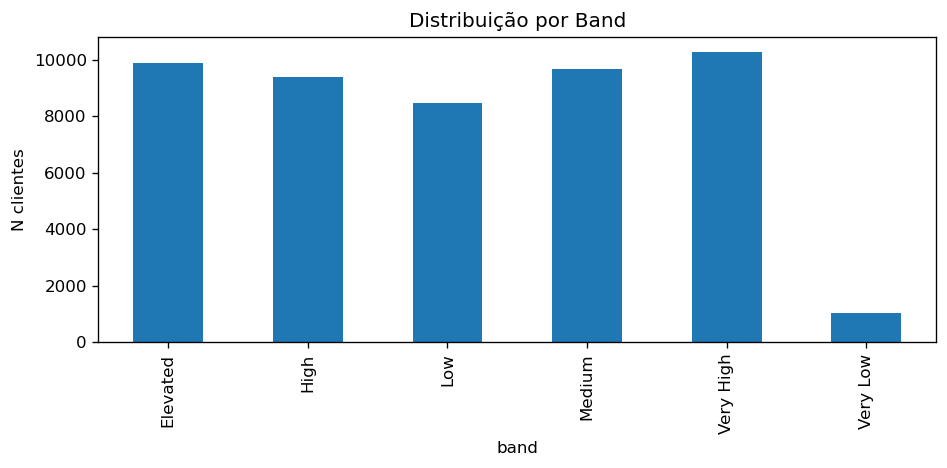

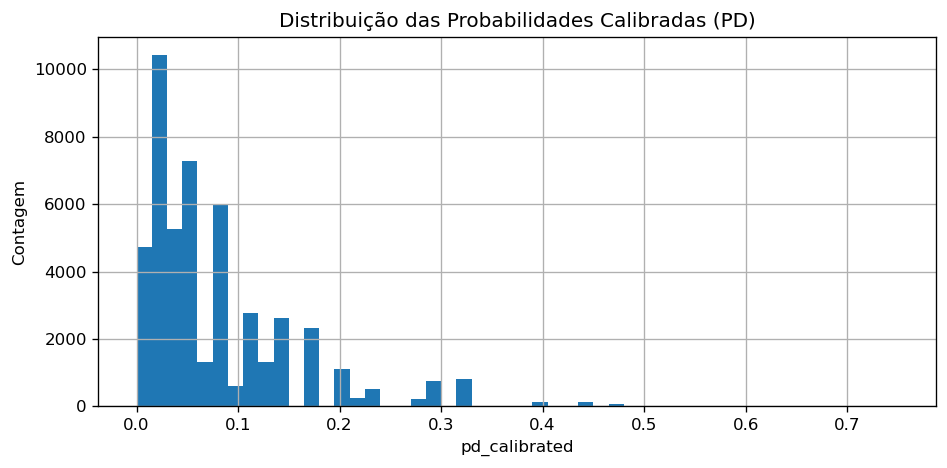

✔ Arquivo padronizado salvo em: c:\Users\luizo\Projetos\credit-risk-model\scored_applications_standard.csv


In [34]:
# 5) EDA do scoring (sem label)
print("Decision %:")
print((scored["decision"].value_counts(normalize=True).round(3) * 100).astype(str) + "%")

band_counts = scored["band"].value_counts().sort_index()
band_perc   = (band_counts / band_counts.sum()).round(3) * 100

print("\nBand counts:")
print(band_counts)
print("\nBand %:")
print(band_perc.astype(str) + "%")

plt.figure(figsize=(8,4))
band_counts.plot(kind="bar", title="Distribuição por Band")
plt.ylabel("N clientes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
scored[PD_COL].hist(bins=50)
plt.title("Distribuição das Probabilidades Calibradas (PD)")
plt.xlabel(PD_COL)
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

# Salvar uma versão padrão (útil pro README)
cols_to_keep = ["SK_ID_CURR", PD_COL, "band", "decision"]
if "pd_raw" in scored.columns:
    cols_to_keep.append("pd_raw")
cols_to_keep = [c for c in cols_to_keep if c in scored.columns]
std = scored[cols_to_keep].rename(columns={PD_COL: "pd_calibrated"})
OUT_STD = ROOT / "scored_applications_standard.csv"
std.to_csv(OUT_STD, index=False)
print("✔ Arquivo padronizado salvo em:", OUT_STD)


In [48]:
# 6) Avaliação com TARGET (tentando alinhar automaticamente um scored de TRAIN)
from sklearn.metrics import roc_auc_score, roc_curve

TRAIN_PATH = DATA_RAW / "application_train.csv"  # seu layout
has_label = TRAIN_PATH.exists()
print("Tem label (application_train.csv)?", has_label)

df_eval = None
if not has_label:
    print("ℹ️ Sem label — parte B será pulada.")
else:
    # Carrega apenas SK_ID_CURR e TARGET
    train = pd.read_csv(TRAIN_PATH, usecols=["SK_ID_CURR", "TARGET"])
    train["TARGET"] = train["TARGET"].astype(int)

    def detect_pd_col(df: pd.DataFrame) -> str | None:
        cand = ["pd_calibrated", "pd", "prob_cal", "prob"]
        return next((c for c in df.columns if c.lower() in cand), None)

    def try_merge(scored_df: pd.DataFrame) -> tuple[pd.DataFrame | None, str | None]:
        """Tenta juntar train com o scored_df. Retorna (df_eval, pd_col) ou (None, None) se não houver overlap."""
        if "SK_ID_CURR" not in scored_df.columns:
            return None, None
        pd_col = detect_pd_col(scored_df)
        if pd_col is None:
            return None, None
        overlap = set(train["SK_ID_CURR"]).intersection(set(scored_df["SK_ID_CURR"]))
        print(f"→ Overlap com este scored: {len(overlap)} IDs")
        if len(overlap) == 0:
            return None, None
        merged = train.merge(scored_df[["SK_ID_CURR", pd_col]], on="SK_ID_CURR", how="inner").dropna()
        return merged, pd_col

    # 1) Tenta com o scored carregado nas células anteriores
    df_eval, pd_col_eval = try_merge(scored)

    # 2) Se não houver overlap, tenta automaticamente outros arquivos típicos de TRAIN
    if df_eval is None:
        candidates_alt = [
            ROOT / "scored_train.csv",
            ROOT / "scored_train_small.csv",
            DATA_RAW / "scored_train.csv",
            DATA_RAW / "scored_train_small.csv",
        ]
        alt_path = next((p for p in candidates_alt if p.exists()), None)
        if alt_path is not None:
            print(f"⚠️ O scored atual não cruza com o train. Tentando arquivo alternativo: {alt_path}")
            scored_alt = pd.read_csv(alt_path)
            df_eval, pd_col_eval = try_merge(scored_alt)
            if df_eval is not None:
                # Atualiza variáveis globais para as próximas células (7–9)
                SCORED_PATH = alt_path
                scored = scored_alt
                PD_COL = pd_col_eval

    # 3) Resultado final
    if df_eval is not None and len(df_eval) > 0:
        print("eval shape:", df_eval.shape)
    else:
        print(
            "❗ Não foi possível montar um conjunto rotulado para avaliação (overlap=0).\n"
            "Gere um scored do TRAIN e rode novamente a Parte B.\n"
            "Sugestão: use a célula de geração rápida (scored_train_small.csv) ou a completa (scored_train.csv)."
        )


Tem label (application_train.csv)? True
→ Overlap com este scored: 7511 IDs
eval shape: (7511, 3)


AUC: 0.8356
KS:  0.5056


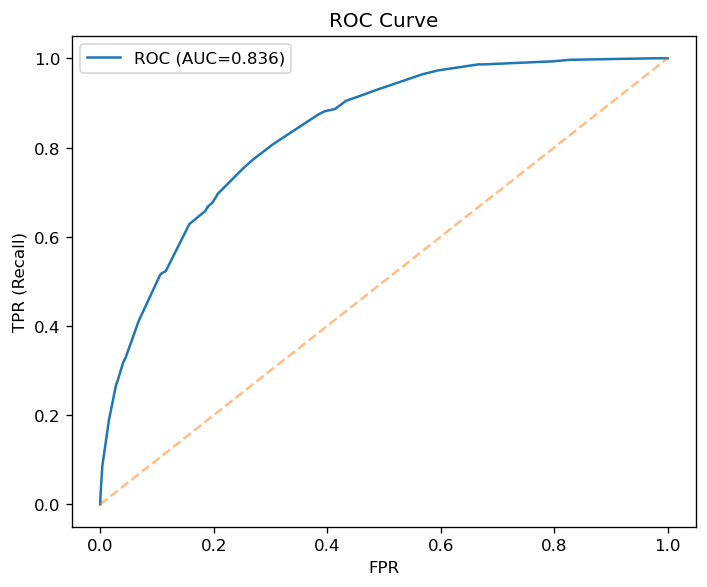

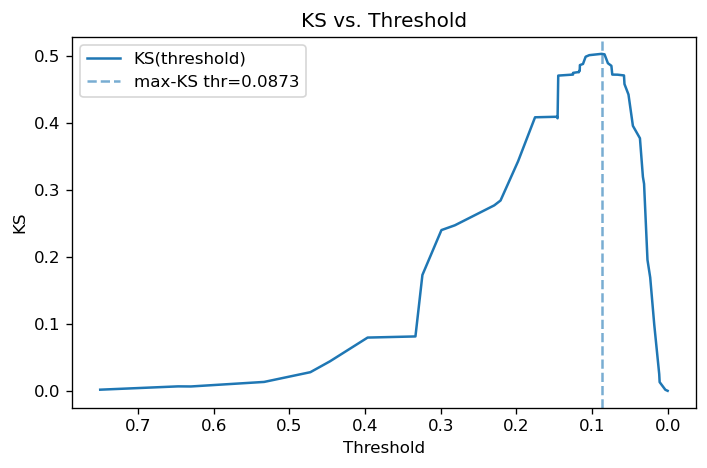

Max-KS threshold (ROC grid): 0.087302 — KS=0.5036


In [49]:
# 7) Métricas globais e curvas
if df_eval is not None and len(df_eval) > 0:
    y_true = df_eval["TARGET"].values
    y_prob = df_eval[PD_COL].values

    auc = roc_auc_score(y_true, y_prob)
    ks  = ks_stat(y_true, y_prob)
    print(f"AUC: {auc:.4f}")
    print(f"KS:  {ks:.4f}")

    fpr, tpr, thr = roc_curve(y_true, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],"--", alpha=0.5)
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    ks_values = tpr - fpr
    best_idx = int(np.argmax(ks_values))
    best_thr = float(thr[best_idx])

    plt.figure(figsize=(6,4))
    plt.plot(thr, ks_values, label="KS(threshold)")
    plt.axvline(best_thr, ls="--", alpha=0.6, label=f"max-KS thr={best_thr:.4f}")
    plt.gca().invert_xaxis()  # sklearn entrega thresholds decrescentes
    plt.xlabel("Threshold")
    plt.ylabel("KS")
    plt.title("KS vs. Threshold")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Max-KS threshold (ROC grid): {best_thr:.6f} — KS={ks_values[best_idx]:.4f}")
else:
    print("ℹ️ Sem df_eval rotulado — pulando AUC/KS.")


In [50]:
# 8) P@k / R@k — apenas com label
if df_eval is not None and len(df_eval) > 0:
    for k in [0.1, 0.2, 0.3]:
        p, r, topn = precision_recall_at_k(df_eval["TARGET"].values, df_eval[PD_COL].values, k)
        print(f"P@{int(k*100)}% = {p:.3f} | R@{int(k*100)}% = {r:.3f} | topN={topn}")
else:
    print("ℹ️ Sem df_eval rotulado — pulando P@k/R@k.")


P@10% = 0.330 | R@10% = 0.421 | topN=751
P@20% = 0.249 | R@20% = 0.635 | topN=1502
P@30% = 0.200 | R@30% = 0.764 | topN=2253


In [51]:
# 9) Métricas no threshold salvo (THR do JSON)
if df_eval is not None and len(df_eval) > 0:
    y_true = df_eval["TARGET"].values
    y_prob = df_eval[PD_COL].values
    y_hat  = (y_prob >= THR).astype(int)

    TP = int(((y_hat == 1) & (y_true == 1)).sum())
    FP = int(((y_hat == 1) & (y_true == 0)).sum())
    TN = int(((y_hat == 0) & (y_true == 0)).sum())
    FN = int(((y_hat == 0) & (y_true == 1)).sum())

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    approval  = float((y_hat == 0).mean())  # abaixo do threshold = Approve
    base_rate = float(y_true.mean())

    print(f"Threshold (JSON): {THR:.6f}")
    print(f"TP={TP} FP={FP} TN={TN} FN={FN}")
    print(f"precision={precision:.3f} recall={recall:.3f} f1={f1:.3f}")
    print(f"approval_rate={approval:.3f} base_rate={base_rate:.3f}")
else:
    print("ℹ️ Sem df_eval rotulado — pulando métricas no threshold salvo.")


Threshold (JSON): 0.083421
TP=475 FP=2101 TN=4821 FN=114
precision=0.184 recall=0.806 f1=0.300
approval_rate=0.657 base_rate=0.078
